In [1]:
%cd "/gscratch/xlab/alisaliu/hack-tokenizers"

[Errno 2] No such file or directory: '/gscratch/xlab/alisaliu/hack-tokenizers'
/Users/sabrinavan/Documents/Princeton/Spring2025/cos484/COS484_final_proj


In [6]:
from pathlib import Path
import json
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from myUtils import read_predictions, mse, read_json, get_pair_to_byte_ratios, score_solution, read_predictions
from train_mixed_tokenizer import sample_from_unit_simplex
import seaborn as sns
import pandas as pd
import numpy as np
import string
import itertools

In [3]:
# MIXTURE_TYPES = ['languages', 'code', 'domains']

MIXTURE_TYPES = ['languages'] # change this!

In [4]:
from matplotlib import font_manager
import colorsys
import matplotlib.colors as mcolors

font_dir = ["../FONTS"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

plt.rcParams.update({
    "font.family": "Macho",
    "axes.linewidth": 1.5,
    "axes.edgecolor": "#333333",
    "axes.labelcolor": "#333333",
    "axes.titlecolor": "#333333",
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "legend.labelcolor": "#333333",
    "text.color": "#333333",
    "font.size": 14,
})

# Main Experiments (§4)

In [5]:
mses = {m: defaultdict(list) for m in MIXTURE_TYPES + ['random', 'uniform']}
dummy_codes = [''.join(tup) for tup in itertools.product(string.ascii_lowercase, string.ascii_lowercase)]
solvedPer = {5:5, 10: 2, 30: 1, 112:1}   # change this to numberof files in each experiment type !

for n in [5, 10, 30, 112]:  # change this to each experiment type !
    for mixture_type in MIXTURE_TYPES:
        experiment_dir = Path(f'experiments/mixed_{mixture_type}/n_{n}')
        if os.path.exists(experiment_dir):
            for test_id in tqdm(range(solvedPer[n]), desc=f'{mixture_type}, n={n}'):
                solved = False
                for T in [30000]:
                    try:
                        # score solutio in utils - calculates mse
                        s = score_solution(experiment_dir / str(test_id), f'solution_pairs_{T}.json')
                        print(s)
                        mses[mixture_type][n].append(s)
                        solved = True
                        break
                    except FileNotFoundError:
                        print('filenotfound')
                        continue
                if not solved:
                    print(f'mixed_{mixture_type}/n_{n}/{test_id}')
    
    # calculate random accuracy
    for _ in tqdm(range(10**6), desc=f'random, n={n}'):
        true = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        pred = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        s = mse(true, pred)
        mses['random'][n].append(s)

    # calculate accuracy of uniform guess
    for _ in tqdm(range(10**6), desc=f'uniform, n={n}'):
        true = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        pred = {l: 1/n for l in dummy_codes}
        s = mse(true, pred)
        mses['uniform'][n].append(s)

languages, n=5: 100%|██████████| 5/5 [00:00<00:00, 22.34it/s]


3.666500710354044e-08
1.3151749345629614e-08
2.3859343409679777e-09
2.905397217128654e-09
3.784874743464572e-09


languages, n=10: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


4.158052915630846e-09
1.0240364920050845e-08


languages, n=30: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


1.8579227397132849e-09


languages, n=112: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


3.2919311924597154e-09


uniform, n=112: 100%|██████████| 1000000/1000000 [03:10<00:00, 5260.35it/s]


In [ ]:
for mixture_type in MIXTURE_TYPES + ['random', 'uniform']:
    for n in [5, 10, 30, 112]: # change this
        if n in mses[mixture_type]:
            l = [np.log10(s) for s in mses[mixture_type][n]]
            print(f'{mixture_type}, n={n}: {np.around(np.mean(l), 2)} +- {np.around(np.std(l), 2)}')

languages, n=112: -8.48 +- 0.0
random, n=112: -3.82 +- 0.07
uniform, n=112: -4.12 +- 0.08


In [17]:
n = 112
test_id = 0
mixture_type = "languages"
T = 30000
experiment_dir = Path(f'/Users/sabrinavan/Documents/Princeton/Spring2025/cos484/COS484_final_proj/experiments/mixed_{mixture_type}/n_{n}')
score_solution(experiment_dir / str(test_id), f'solution_pairs_{T}.json')

test_dir = experiment_dir / str(test_id)
solution_file = f'solution_pairs_{T}.json'

preds = read_predictions(test_dir / solution_file)
meta = read_json(test_dir / 'meta.json')
truth = {k: v / sum(meta['byte_count'].values()) for k, v in meta['byte_count'].items()}
pair_to_byte_ratio = get_pair_to_byte_ratios(test_dir, num_bytes=0)

converted_preds = {}
for lang, p in preds.items():
    converted_preds[lang] = p * pair_to_byte_ratio[lang]
converted_preds = {k: v / sum(converted_preds.values()) for k, v in converted_preds.items()}

print(converted_preds)


{'ro': 0.00027821511926789537, 'ku': 0.00030088741348101126, 'mk': 0.0002978725406369836, 'hi': 0.0004850808518008554, 'ko': 0.0005946342175687224, 'he': 0.0006074980981965975, 'yi': 0.0007981208653290779, 'tr': 0.0009758112319799436, 'azb': 0.0009910891505101034, 'pa': 0.0013111912832313403, 'sh': 0.0013133603108852177, 'bn': 0.0014025285738020205, 'ky': 0.0013021841928405227, 'eo': 0.0015618735680014812, 'da': 0.001538188771096458, 'gu': 0.00170162388118152, 'sd': 0.0014973368691491627, 'new': 0.0018479168555297148, 'ms': 0.0017478805365175347, 'ml': 0.002000810923983658, 'uz': 0.001800776558864793, 'ug': 0.0019241194187449113, 'br': 0.0024780466020037795, 'ar': 0.0022443247784251167, 'vi': 0.002617845248289485, 'si': 0.003095347510311084, 'pl': 0.0029317632189001155, 'it': 0.003074069697087206, 'be': 0.0027709872833119454, 'sv': 0.003070027894308601, 'pnb': 0.003108651261277026, 'fr': 0.0036689285763280076, 'ru': 0.003496649966244916, 'als': 0.004039369761782018, 'mhr': 0.0037936477

# Distribution shift analysis (§6.1)

In [ ]:
experiment_dir = Path(f'experiments/mixed_languages_shift/n_112')
mses = {}

for e in [6, 7, 8, 9, 10]:
    mses[e] = defaultdict(list)
    for test_id in tqdm(range(100), desc=f'1e{e:02d}'):
        for T in [100, 300, 1000, 3000, 10000, 29772]:
            s = score_solution(experiment_dir / str(test_id), f'solution6_pairs_{T}_1e{e:02d}.json', num_bytes=10**e)
            mses[e][T].append(s)

1e06:   0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sabrinavan/Documents/Princeton/Spring2025/cos484/COS484_final_proj/experiments/mixed_languages_shift/n_112/0/solution_pairs_30000.json'

In [18]:
D_col, T_col, score_col = [], [], []

for e, data in mses.items():
    for T, scores in data.items():
        for s in scores:
            D_col.append(10**e)
            T_col.append(T)
            score_col.append(s)

In [19]:
data = pd.DataFrame({'D': D_col, 'T': T_col, 'MSE': score_col})

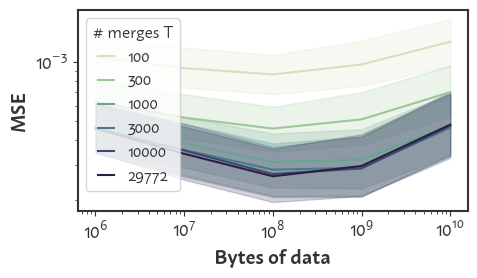

In [20]:
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('Bytes of data', fontweight='semibold')
ax.set_ylabel('MSE', fontweight='semibold')
sns.lineplot(data=data, x='D', y='MSE', hue='T', palette=sns.cubehelix_palette(start=.5, rot=-.75, n_colors=6))
ax.legend(title='# merges T', loc='upper left', fontsize=12, title_fontsize=12, handlelength=1)
plt.tight_layout()
plt.savefig('plots/shift_bytes_data_scaling.pdf', dpi=300)

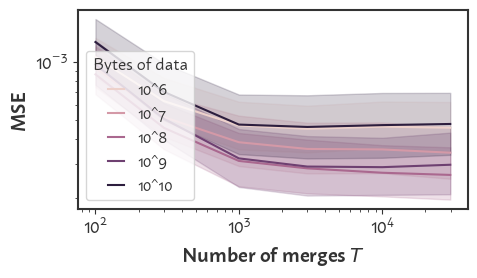

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('Number of merges $T$', fontweight='semibold')
ax.set_ylabel('MSE', fontweight='semibold')
data['e'] = [f'10^{int(np.log10(d))}' for d in data['D']]
sns.lineplot(data=data, x='T', y='MSE', hue='e', palette=sns.cubehelix_palette(n_colors=5))
ax.legend(title='Bytes of data', loc='lower left', fontsize=12, title_fontsize=12, handlelength=1)
plt.tight_layout()
plt.savefig('plots/shift_num_merges_scaling.pdf', dpi=300)

# Unaccounted-for languages analysis (§6.2)

In [22]:
experiment_dir = Path('experiments/mixed_languages/n_112')

In [25]:
mses = []
for test_id in tqdm(range(100)):
    test_id = str(test_id)
    for n_omit in [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
        solution_file = f'solution6_pairs_29778_langlist_omit{n_omit}.json'
        try:
            preds = read_predictions(experiment_dir / test_id / solution_file)
        except FileNotFoundError:
            continue
        
        meta = read_json(experiment_dir / test_id / 'meta.json')
        truth = {k: v / sum(meta['byte_count'].values()) for k, v in meta['byte_count'].items()}

        included_langs = [l.rstrip() for l in open(experiment_dir / test_id / f'langlist_omit{n_omit}.txt').readlines()]
        prob_omitted = sum([v for k, v in truth.items() if k not in included_langs])
        renorm_truth = {k: v for k, v in truth.items() if k in included_langs}
        renorm_truth = {k: v / sum(renorm_truth.values()) for k, v in renorm_truth.items()}
        assert len(renorm_truth) == 112 - n_omit
        
        pair_to_byte_ratio = get_pair_to_byte_ratios(experiment_dir / test_id)
        
        converted_preds = {}
        for lang, p in preds.items():
            converted_preds[lang] = p * pair_to_byte_ratio[lang]
        converted_preds = {k: v / sum(converted_preds.values()) for k, v in converted_preds.items()}
        
        s = mse(renorm_truth, converted_preds)
        
        mses.append({
            'test_id': int(test_id),
            'n_omit': n_omit,
            'prob_omitted': prob_omitted,
            'mse': s
        })

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


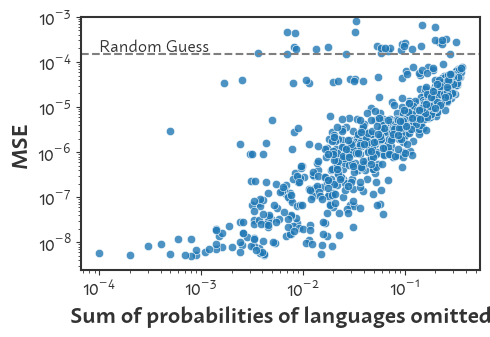

In [26]:
x = [ex['prob_omitted'] for ex in mses]
y = [ex['mse'] for ex in mses]
fig, ax = plt.subplots(figsize=(6.4*4/5,4.8*3/4))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(x=x, y=y, alpha=0.8)
ax.set_xlabel('Sum of probabilities of languages omitted', fontsize=16, fontweight='semibold')
ax.set_ylabel('MSE', fontsize=16, fontweight='semibold')
ax.set_ylim(top=10**-3)

# Add horizontal line at log_10(-3.82)
log_rand_guess = -3.82
ax.axhline(y=10**log_rand_guess, color=sns.color_palette()[-3], linestyle='--', label='Random Guessing')

# Label for the horizontal line
ax.text(min(x), 10**log_rand_guess, 'Random Guess', fontsize=12, verticalalignment='bottom')

plt.tight_layout()
plt.savefig('plots/missing_lang.png', dpi=300)
plt.savefig('plots/missing_lang.pdf', dpi=300)